In [1]:
import tensorflow as tf
from keras.preprocessing import image
import keras.backend as K
from keras.applications.inception_v3 import preprocess_input
import numpy as np
import cv2

import matplotlib.pyplot as plt 

In [ ]:
model_heat_class = tf.keras.models.load_model('/content/drive/MyDrive/redes_heat/model_v3.h5')
model_seg = tf.keras.models.load_model('/content/drive/MyDrive/unet.h5',compile = False)

In [ ]:
# segmentation

def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255.
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        cv2.imwrite(save_path, img)       

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray,)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret 

# heatmap

def load_img_heat(img_ad,DIM = 150):

  ORIGINAL = img_ad
  img = image.load_img(ORIGINAL, target_size=(DIM, DIM))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  return x

def heatmap_generation(model,x):

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv2d_85')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

  return heatmap

def add_colored_heatmap (heatmap,ORIGINAL):

  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((3, 3))

  img = cv2.imread(ORIGINAL)
  INTENSITY = 0.3

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * INTENSITY + img
  
  return img

In [ ]:
img = '/content/covid-19-pneumonia-80.jpg' # Diagnosis input


# segmentation generation

test_gen = test_load_image(img, target_size=(512,512))
result = model_seg.predict(test_gen,verbose = 1)
save_result('predict.png', result ,img)
img_seg = cv2.imread(img)
img_seg = cv2.resize(img_seg, (1000,1000))
predict_image = cv2.imread("predict.png")
predict_image = cv2.resize(predict_image, (1000,1000))
img_seg = add_colored_mask(img_seg,predict_image )

# heatmap generation

img_processed = load_img_heat(img)
heatmap = heatmap_generation(model_heat_class,img_processed)
img_heatmap = add_colored_heatmap(heatmap,img)

# prediction

preds = model_heat_class.predict(img_processed)
print(preds)

# save images 

cv2.imwrite('segmentation.png', img_seg)
cv2.imwrite('heatmap.png', img_heatmap)

1/1 [==============================] - 2s 2s/step
[[8.7547157e-08 9.9091572e-01 9.0466561e-03 1.1256200e-05 2.6277792e-05]]


True

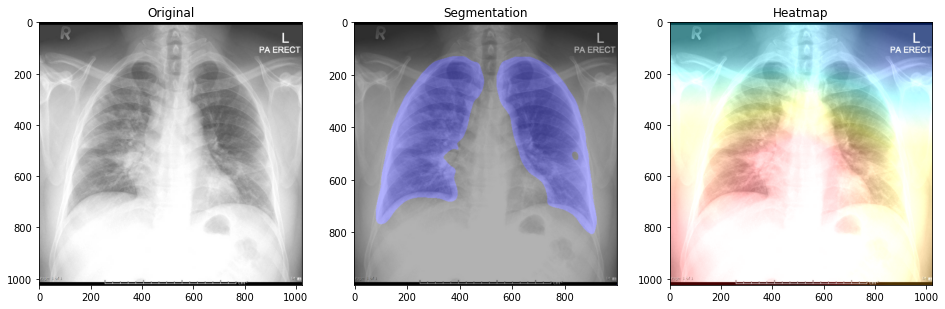

In [ ]:
# plot images

fig, axs = plt.subplots(1, 3, figsize=(16, 16))

axs[0].set_title("Original")
axs[0].imshow(cv2.imread(img))
axs[1].set_title("Segmentation")
axs[1].imshow(cv2.cvtColor(img_seg, cv2.COLOR_BGR2RGB))
axs[2].set_title("Heatmap")
axs[2].imshow(cv2.cvtColor(cv2.imread("heatmap.png"), cv2.COLOR_BGR2RGB))